# Data

In [1]:
import pandas as pd
doc2topic = pd.read_csv("doc2topic.csv")
doc2topic.set_index("doc_id",inplace=True)

emotions = pd.read_pickle("../data/emotions_compressed.pkl.gz")
emotions = emotions.join(doc2topic['topic'])

# check against aggregated emotions

emotions_agg = pd.read_csv("emotions.csv")
emotions_agg.set_index("Topic",inplace=True)
assert (emotions.groupby('topic').mean()-emotions_agg).abs().max().max() < 1e-4

/tmp/ipykernel_517343/1161005462.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Insights

Biggest fear occurs in topics related to pandemia and the war on Ukraine.

In [2]:
emotions_agg.sort_values("fear",ascending=False).head(6)

,sadness,disgust,pessimism,anger,anticipation,joy,fear,optimism,surprise,trust,love
Topic,,,,,,,,,,,
2,0.072572,0.283825,0.068204,0.258969,0.404288,0.137749,0.481284,0.214518,0.073049,0.064235,0.010926
56,0.112782,0.396744,0.080592,0.362464,0.350235,0.105353,0.478799,0.155787,0.081483,0.047406,0.008637
61,0.208532,0.239893,0.145550,0.179963,0.376131,0.147433,0.404765,0.337837,0.057601,0.074166,0.011487
99,0.144684,0.170082,0.085544,0.125447,0.389993,0.317713,0.328546,0.398602,0.064985,0.065424,0.023875
60,0.226947,0.312838,0.135836,0.255518,0.375404,0.190973,0.275193,0.305734,0.075159,0.069927,0.015099
19,0.082476,0.198030,0.072334,0.182618,0.507511,0.299126,0.254994,0.446743,0.073088,0.127018,0.021420


Note that the standard deviations within clusters are huge.

In [3]:
emotions_agg_mu = emotions.groupby("topic").median().round(3)
emotions_agg_std = emotions.groupby("topic").std().round(3)

pd.concat([emotions_agg_mu.astype(str),emotions_agg_std.astype(str)]).groupby("topic").agg(lambda s: '+'.join(map(str,s))).loc[[60,61,99]]

,sadness,disgust,pessimism,anger,anticipation,joy,fear,optimism,surprise,trust,love
topic,,,,,,,,,,,
60,0.103+0.267,0.175+0.304,0.091+0.133,0.102+0.294,0.367+0.236,0.052+0.267,0.146+0.287,0.166+0.312,0.051+0.073,0.034+0.084,0.006+0.039
61,0.097+0.243,0.123+0.256,0.102+0.129,0.068+0.239,0.38+0.214,0.046+0.223,0.335+0.312,0.205+0.32,0.042+0.057,0.036+0.088,0.006+0.027
99,0.053+0.212,0.087+0.212,0.047+0.102,0.053+0.191,0.398+0.211,0.193+0.311,0.273+0.278,0.363+0.304,0.05+0.056,0.043+0.068,0.008+0.069


This is partly because emotion distributions are not only skewed but also multimodal.

<Axes: ylabel='Frequency'>

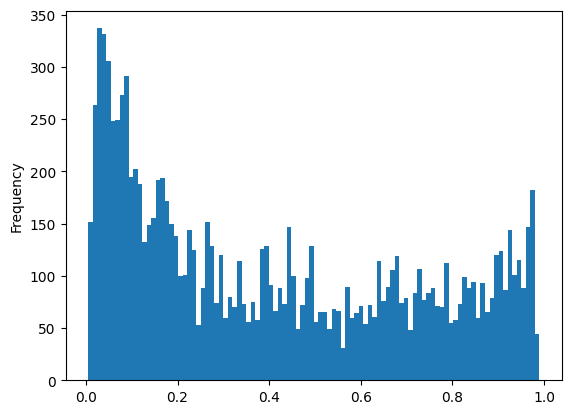

In [4]:
mask = emotions['topic']==61

emotions.loc[mask,'fear'].plot(kind='hist',bins=100)

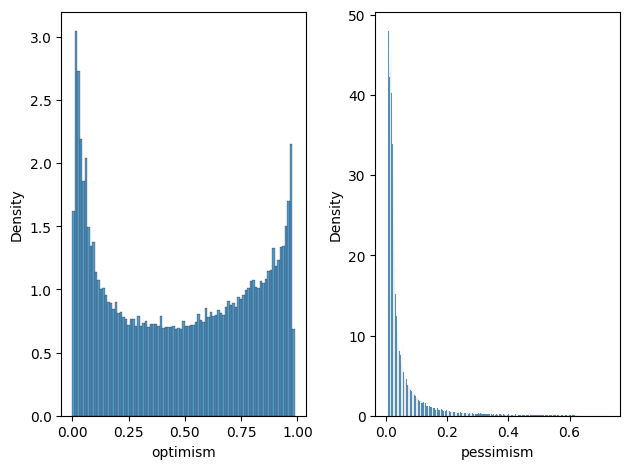

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

fig,axs = plt.subplots(1,2)

ax = axs[0]
sns.histplot(emotions['optimism'],stat='density',ax=ax,label='optimism')

ax = axs[1]
sns.histplot(emotions['pessimism'],stat='density',ax=ax,label='pessimism')

plt.tight_layout()

Let's analyse optimism and pessimism but approximate them from Plutchik’s “wheel of emotions”.

In [6]:
pessimism = 0.5*emotions["anticipation"] + 0.5*emotions["sadness"]# - emotions["anticipation"] * emotions["sadness"]
optimism = 0.5*emotions["anticipation"] + 0.5*emotions["joy"]# - emotions["anticipation"] * emotions["joy"]
emotions_corr = pd.DataFrame({"pessimism":pessimism,"optimism":optimism,"topic":emotions["topic"]})

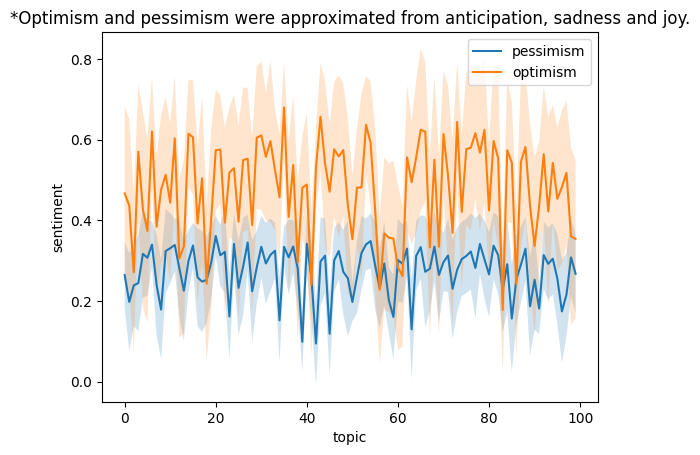

In [7]:
import matplotlib.pyplot as plt

emotions_df = emotions_corr

fig,ax = plt.subplots()
for kpi in ["pessimism", "optimism"]:
    y = emotions_df.groupby("topic")[kpi].mean()
    error = emotions_df.groupby("topic")[kpi].std()
    ax.plot(y,label=kpi)
    ax.fill_between(y.index,y-error, y+error,alpha=0.2)
    
ax.set_xlabel("topic")
ax.set_ylabel("sentiment")
ax.legend()
plt.title("*Optimism and pessimism were approximated from anticipation, sadness and joy.")
plt.show()

All topics have positive mean sentiment, perhaps except one topic about the war...

In [8]:
from scipy.stats import ttest_ind

pvals = {}

emotions_df = emotions_corr

for topic,idxs in emotions.groupby("topic").groups.items():
    x = emotions_df.loc[idxs,"optimism"]
    y = emotions_df.loc[idxs,"pessimism"]
    pval = ttest_ind(x,y,equal_var=False).pvalue
    pvals[topic] = pval

pvals = pd.Series(pvals)
pvals.sort_values(ascending=False).head()
#emotions[["optimism","pessimism","topic"]].groupby("topic").groups

56    1.906642e-02
18    4.610388e-09
38    2.717394e-11
86    3.059999e-12
60    8.218752e-18
dtype: float64